In [106]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

In [107]:
target = 'Close'
Stock = pd.read_csv('/kaggle/input/apple-stock-price-from-19802021/AAPL.csv')

df_Stock = Stock
df_Stock = df_Stock.rename(columns={'Close(t)':'Close'})
df_Stock['Date'] = pd.to_datetime(df_Stock['Date'])
start_date = pd.Timestamp('2004-12-31')
df_Stock = df_Stock[df_Stock['Date'] > start_date]
df_Stock.set_index('Date', drop=True, inplace=True)
df_Stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,1.156786,1.162679,1.117857,1.130179,0.966323,691992000
2005-01-04,1.139107,1.169107,1.124464,1.141786,0.976247,1096810400
2005-01-05,1.151071,1.165179,1.143750,1.151786,0.984798,680433600
2005-01-06,1.154821,1.159107,1.130893,1.152679,0.985561,705555200
2005-01-07,1.160714,1.243393,1.156250,1.236607,1.057321,2227450400


In [108]:
df_Stock.shape

(4396, 6)

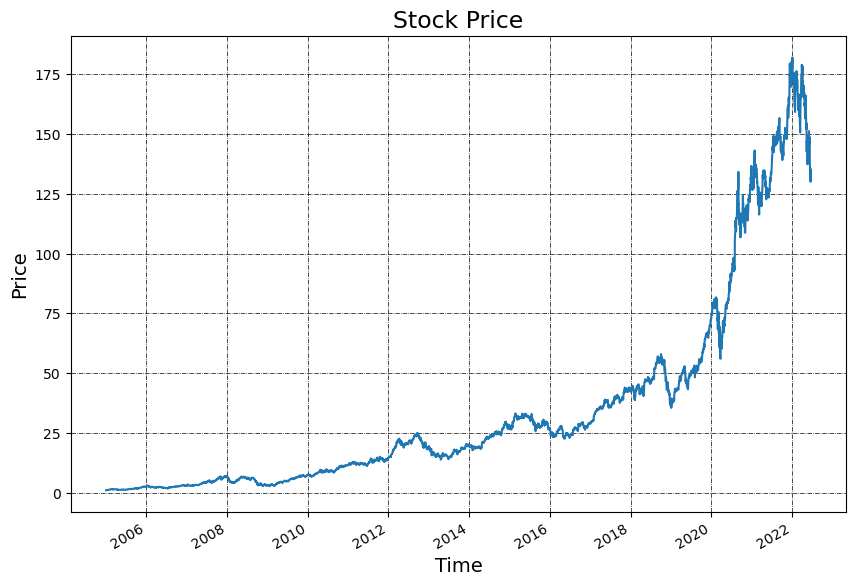

In [109]:
df_Stock[target].plot(figsize=(10, 7))
plt.title("Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

**LSTM Prediction**

In [110]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math 
import os.path
import keras
from tensorflow.keras.models import model_from_json

In [111]:
df = df_Stock
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,1.156786,1.162679,1.117857,1.130179,0.966323,691992000
2005-01-04,1.139107,1.169107,1.124464,1.141786,0.976247,1096810400
2005-01-05,1.151071,1.165179,1.143750,1.151786,0.984798,680433600
2005-01-06,1.154821,1.159107,1.130893,1.152679,0.985561,705555200
2005-01-07,1.160714,1.243393,1.156250,1.236607,1.057321,2227450400
...,...,...,...,...,...,...
2022-06-13,132.869995,135.199997,131.440002,131.880005,131.880005,122207100
2022-06-14,133.130005,133.889999,131.479996,132.759995,132.759995,84784300
2022-06-15,134.289993,137.339996,132.160004,135.429993,135.429993,91533000


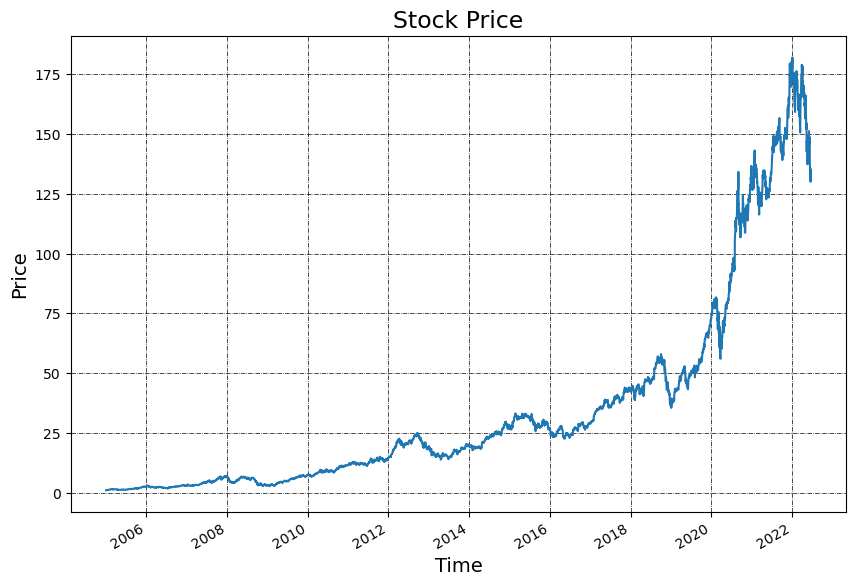

In [112]:
# make timeseries stationary
target_prices = df[target]
# target_prices = np.log(target_prices)
# target_prices = target_prices - target_prices.shift()
# target_prices.dropna(inplace=True)
# plot series
target_prices.plot(figsize=(10, 7))
plt.title("Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [113]:
features = df.loc[:, df.columns != target]
features = features.shift().dropna()
features = features.values
target_values = target_prices.values[1:]

In [114]:
window = 20 # day window
train_perc, val_perc, test_perc = 0.88, 0.1, 0.02

training_data_len = math.ceil(len(target_values)* train_perc)
validation_data_len = math.ceil(len(target_values)* val_perc)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(target_values.reshape(-1,1))
# features scaler 
f_scaler = MinMaxScaler(feature_range=(0,1))
scaled_features = f_scaler.fit_transform(features.reshape(-1,5))

# dataset split
X_train, Y_train = scaled_features[0: training_data_len, :], scaled_data[0: training_data_len, :]
val_lim = training_data_len+validation_data_len
X_val, Y_val = scaled_features[training_data_len:val_lim, :], scaled_data[training_data_len:val_lim, :]
X_test, Y_test = scaled_features[val_lim:, :], scaled_data[val_lim:, :]

# reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [115]:
train_model = False
best_weights_path = '/kaggle/working/best_params_all.hdf5'

model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(layers.LSTM(100, return_sequences=True))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(10))
model.add(layers.Dense(1))
# model.add(layers.LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(layers.LSTM(10, return_sequences=False))
# model.add(layers.Dense(25))
# model.add(layers.Dense(10))
# model.add(layers.Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5, 100)            40800     
                                                                 
 lstm_15 (LSTM)              (None, 100)               80400     
                                                                 
 dense_18 (Dense)            (None, 25)                2525      
                                                                 
 dense_19 (Dense)            (None, 10)                260       
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
Total params: 123,996
Trainable params: 123,996
Non-trainable params: 0
_________________________________________________________________


In [116]:
if not os.path.exists(best_weights_path) or train_model:
    model.compile(optimizer='adam', loss='mean_squared_error')
    checkpoint = ModelCheckpoint(best_weights_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
    with tf.device('/gpu:0'):
        history = model.fit(X_train, Y_train, batch_size= 32, epochs=50, callbacks=[checkpoint])
    print("Saved model to disk")

In [117]:
if os.path.exists(best_weights_path) and not train_model:
    # load model params
    model.load_weights(best_weights_path)
    print("Loaded model from disk")

Loaded model from disk


In [118]:
# validation
Y_val_pred = model.predict(X_val)
# reverse transformations
Y_val_pred = scaler.inverse_transform(Y_val_pred) # transform to original scale
Y_val = scaler.inverse_transform(Y_val) # transform to original scale
# test
Y_test_pred = model.predict(X_test)
# reverse transformations
Y_test_pred = scaler.inverse_transform(Y_test_pred) # transform to original scale
Y_test = scaler.inverse_transform(Y_test) # transform to original scale

3/3 [==============================] - 0s 5ms/step


In [119]:
def get_error_values(Y_real, Y_pred):
    mse = metrics.mean_squared_error(Y_real, Y_pred)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(Y_real, Y_pred)
    return mse, rmse, mae

In [120]:
mse, rmse, mae = get_error_values(Y_val, Y_val_pred)
print("*** Validation data ***")
print("The mean squared error is {:.2f}".format(mse))
print("The root mean squared error is {:.2f}".format(rmse))
print("The absolute mean error is {:.2f}".format(mae))
mse, rmse, mae = get_error_values(Y_test, Y_test_pred)
print("*** Test data ***")
print("The mean squared error is {:.2f}".format(mse))
print("The root mean squared error is {:.2f}".format(rmse))
print("The absolute mean error is {:.2f}".format(mae))

*** Validation data ***
The mean squared error is 8.89
The root mean squared error is 2.98
The absolute mean error is 2.23
*** Test data ***
The mean squared error is 20.06
The root mean squared error is 4.48
The absolute mean error is 3.67


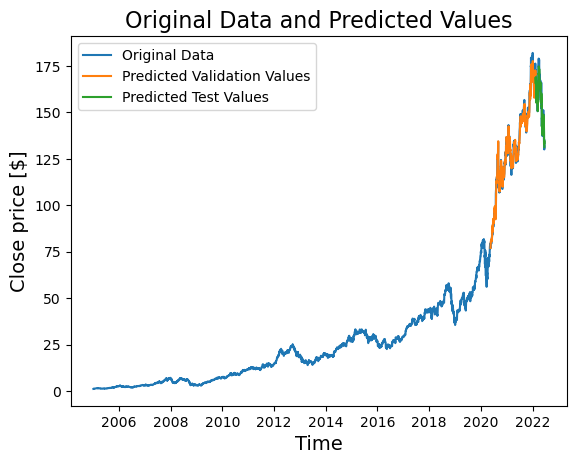

In [121]:
import matplotlib.pyplot as plt
df = df.iloc[1:,:]
# Plot the original data and the predicted values
plt.plot(df.index, df['Close'], label='Original Data')
plt.plot(df.index[training_data_len:training_data_len+validation_data_len], Y_val_pred, label='Predicted Validation Values')
plt.plot(df.index[training_data_len+validation_data_len:], Y_test_pred, label='Predicted Test Values')
plt.xlabel('Time', fontdict={'fontsize':14})
plt.ylabel('Close price [$]', fontdict={'fontsize':14})
# plt.xlim(0, 305) to be defined
# plt.ylim(35, 190)
plt.title(f'Original Data and Predicted Values', fontdict={'fontsize':16})
plt.legend()
plt.savefig('ltsm_all_simple_model.png', dpi=900)
plt.show()